This notebook presents the results of our experiments on the LANL dataset. In order to run it, you can either use the JSON result file provided in the repository (`results/lanl.json`) or reproduce the experiments (see `README.md`).

In [1]:
import json

import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
file_path = '../results/lanl.json'
dat = json.loads(open(file_path).read())
print(dat.keys())

dict_keys(['top', 'bottom', 'thetas', 'counts'])


The JSON file containing the results has four main keys: `top` (resp. `bottom`) contains a list of dictionaries representing the top (resp. bottom) clusters, `thetas` contains the rate matrices $\mathbf{\Theta}_{hk}^{(\ell)}$ corresponding to the different edge types, and `counts` contains the total event counts for each (top cluster, bottom cluster, edge type) triple.

Recall that top nodes represent users while bottom nodes represent hosts. First of all, let's look at the size of the clusters.

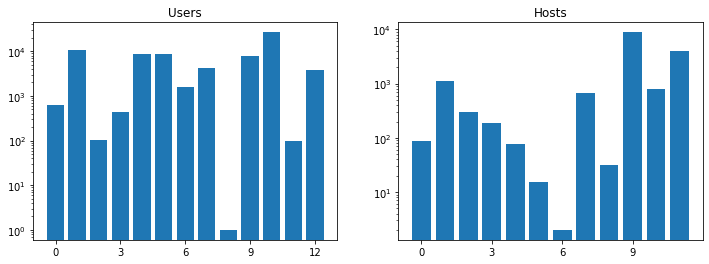

In [3]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for i, t in enumerate([('top', 'Users'), ('bottom', 'Hosts')]):
    axes[i].bar(
        list(range(len(dat[t[0]]))),
        [len(x) for x in dat[t[0]]]
    )
    axes[i].set_yscale('log')
    axes[i].set_xticks([j for j, _ in enumerate(dat[t[0]]) if j % 3 == 0])
    axes[i].set_title(t[1])
plt.show()

There are quite a few clusters containing thousands of nodes, which makes sense considering that there are roughly 74,000 users and 16,000 hosts in the dataset. It is thus difficult to manually inspect the contents of each cluster. However, we can still extract some information about user clusters using naming conventions. Indeed, while user names are anonymized, built-in and computer accounts can still be distinguished from standard user accounts, allowing us to describe the dominant functional role of each cluster.

In [4]:
print('Cluster\tSize\tLocal accounts\tComputer accounts\tService accounts\tAnonymous logons')
for i, x in enumerate(dat['top']):
    loc = sum('@C' in s for s in x)/len(x) if len(x) > 0 else 0
    comp = sum(s[0] == 'C' for s in x)/len(x) if len(x) > 0 else 0
    anon = sum(s.startswith('ANONYMOUS') for s in x)/len(x) if len(x) > 0 else 0
    bltn = sum(s[0] not in ('U', 'C', 'A') for s in x)/len(x) if len(x) > 0 else 0
    print(
        '%d\t%d\t%.3f\t\t%.3f\t\t\t%.3f\t\t\t%.3f' % (i+1, len(x), loc, comp, bltn, anon)
    )

Cluster	Size	Local accounts	Computer accounts	Service accounts	Anonymous logons
1	617	0.668		0.003			0.000			0.002
2	10922	0.098		0.009			0.000			0.001
3	101	0.970		0.000			0.000			0.941
4	448	0.917		0.408			0.451			0.000
5	8856	0.999		0.000			0.000			0.994
6	8799	0.002		0.984			0.000			0.000
7	1612	0.040		0.462			0.000			0.006
8	4217	0.000		0.974			0.000			0.000
9	1	1.000		0.000			0.000			0.000
10	7884	0.999		0.001			0.999			0.000
11	26668	0.997		0.003			0.984			0.000
12	96	0.938		0.052			0.938			0.000
13	3828	0.983		0.005			0.883			0.000


Some clusters are quite homogeneous: for instance, clusters 3 and 5 mostly contain occurrences of "ANONYMOUS LOGON", while clusters 10 and 11 almost exclusively consist of built-in service accounts (i.e. "SYSTEM", "LOCAL SERVICE", "NETWORK SERVICE"). As for clusters 6 and 8, they essentially consist of computer accounts. Together, these 6 clusters account for roughly 56,000 users &mdash; around 75% of the population.

In order to gather some information on the other user clusters as well as the host clusters, we now display the main interactions between clusters.

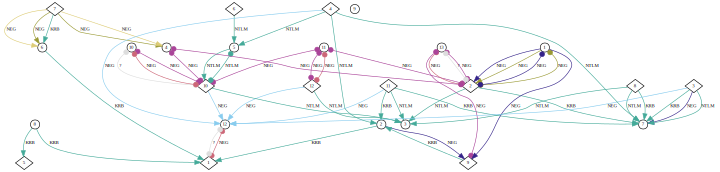

In [5]:
colors = {
    '?': '#dddddd',
    'Interactive': '#999933',
    'CachedInteractive': '#999933',
    'Unlock': '#ddcc77',
    'Network': '#44aa99',
    'NetworkCleartext': '#88ccee',
    'RemoteInteractive': '#332288',
    'Batch': '#882255',
    'Service': '#aa4499',
    'NewCredentials': '#cc6677'
}
abbr = {
    'NTLM': 'NTLM',
    'Kerberos': 'KRB',
    'Negotiate': 'NEG',
    'MSV_1_0': 'MSAP',
    'Wave': 'WAVE',
    'N': '?',
    '?': '?'
}

edges = sorted(
    [(h, k, t)
     for t in dat['thetas']
     for h in range(len(dat['top']))
     for k in range(len(dat['bottom']))
    ],
    key=lambda x: -dat['counts'][x[2]][x[0]][x[1]]
)

g = graphviz.Digraph('lanl', graph_attr={'size': '10'})
THRESHOLD = .7
for h, k, t in edges:
    w = dat['thetas'][t][h][k]
    if w >= THRESHOLD and dat['counts'][t][h][k] > 0:
        u = 'USER-%d' % h
        v = 'HOST-%d' % k
        ap, lt, dn = t.split('-')
        if dn == 'FROM':
            g.edge(v, u, label=abbr[ap], color=colors[lt], fontsize='8')
        elif dn == 'TO':
            g.edge(u, v, label=abbr[ap], color=colors[lt], fontsize='8')
        else:
            g.edge(u, v, label=abbr[ap], color=colors[lt], fontsize='8', dir='both', arrowhead='dot', arrowtail='dot')
for h, x in enumerate(dat['top']):
    g.node('USER-%d' % h, label=str(h+1), shape='circle', fontsize='8', height='.1', width='.1', margin='.02')
for k, x in enumerate(dat['bottom']):
    g.node('HOST-%d' % k, label=str(k+1), shape='diamond', fontsize='8', height='.1', width='.4', margin='.02')

g

While making sense of the whole graph seems rather challenging, focusing on the edges incident to each node helps better understand its role. For instance, coming back to user clusters 10 and 11 (mostly containing service accounts), they behave as expected by authenticating locally with logon types Service and NewCredentials. User cluster 1 also stands out by opening RDP sessions on two host clusters. As for hosts, the direction of remote authentications allows for educated guesses regarding their functional roles: clusters 3, 7, 8, 9, and 11 seem to contain workstations, while cluster 1 is the destination of many remote authentications, suggesting that it contains servers.

Finally, host cluster 4 is the source of many remote NTLM authentications across several user clusters. Let's take a closer look:

In [6]:
full_graph = pd.read_csv('../data/lanl.csv')
user_clusters = {}
for h, x in enumerate(dat['top']):
    for u in x:
        user_clusters[u] = h
host_clusters = {}
for k, x in enumerate(dat['bottom']):
    for c in x:
        host_clusters[c] = k
full_graph['h'] = full_graph['top'].apply(lambda x: user_clusters[x])
full_graph['k'] = full_graph['bottom'].apply(lambda x: host_clusters[x])

In [7]:
partial_graph = full_graph[
    (full_graph['k'] == 3)
    &(full_graph['type'] == 'NTLM-Network-FROM')
]
partial_graph['bottom'].value_counts()

C17693    152
C5821     100
C15650     10
C15408      7
C12828      6
         ... 
C20033      1
C19914      1
C19681      1
C19237      1
C27151      1
Name: bottom, Length: 171, dtype: int64

Two hosts, C17693 and C5821, are responsible for most of these authentications.

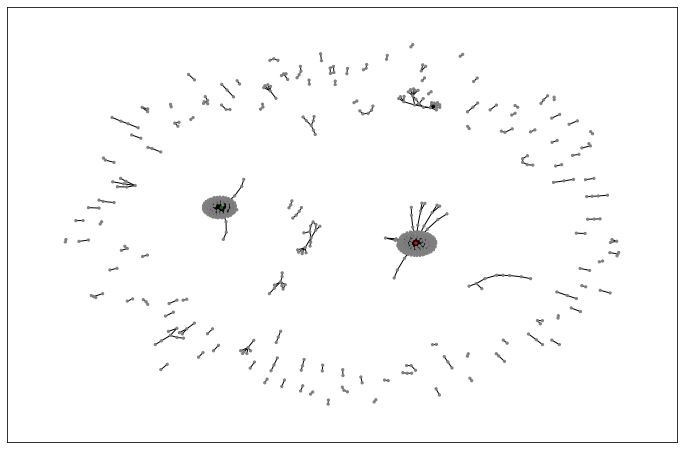

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

g = nx.Graph()
g.add_edges_from([
    (u, v)
    for u, v in zip(partial_graph['top'], partial_graph['bottom'])
])
nodes = sorted(list(g.nodes))
colors = []
for n in nodes:
    if n == 'C17693':
        colors.append('red')
    elif n == 'C5821':
        colors.append('green')
    else:
        colors.append('grey')
nx.draw_networkx(
    g,
    nodelist=nodes,
    node_color=colors,
    with_labels=False,
    ax=ax,
    node_size=5
)

These two hosts clearly stand out, and one of them (C17693) happens to be the main source of red team activity: most of the remote NTLM authentications originating from it were performed by the red team.